# Import necessary libraries

### Data visualization

### No Contrails in this image

## Data visualization with Contrails

### In this image we can see contrails appear

## Load & Preprocess Dataset

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Enable mixed precision for 2-3x speedup
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Load patch IDs
patch_ids = os.listdir(train_path)
print(f"Found {len(patch_ids)} patches")

# SPEED OPTIMIZATION: Use only 25% of data for fast training
patch_ids = patch_ids[:len(patch_ids)//4]  # Use 5000 patches instead of 20000
print(f"Using {len(patch_ids)} patches for fast training")

2025-10-18 09:31:53.594790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760779913.811662      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760779913.876305      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20529 patches
Using 5132 patches for fast training


In [2]:
def compute_band_stats(patch_ids, train_path, sample_size=50):
    """Compute global band statistics from a small sample"""
    band_mins = [np.inf] * 16
    band_maxs = [-np.inf] * 16
    
    sample_ids = np.random.choice(patch_ids, min(sample_size, len(patch_ids)), replace=False)
    
    for pid in tqdm(sample_ids, desc="Computing band stats"):
        patch_folder = os.path.join(train_path, pid)
        
        for b in range(16):
            band_path = os.path.join(patch_folder, f"band_{b+1:02d}.npy")
            if os.path.exists(band_path):
                band_data = np.load(band_path)
                band_mins[b] = min(band_mins[b], band_data.min())
                band_maxs[b] = max(band_maxs[b], band_data.max())
    
    return band_mins, band_maxs

# Compute statistics quickly
band_mins, band_maxs = compute_band_stats(patch_ids, train_path, sample_size=50)
print("Band statistics computed!")

Computing band stats: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

Band statistics computed!


In [3]:
import random
import tensorflow as tf

def fast_generator(patch_ids, train_path, band_mins, band_maxs, batch_size=16, include_negatives=True):
    """Optimized generator with negative samples"""
    while True:
        shuffled_ids = patch_ids.copy()
        np.random.shuffle(shuffled_ids)
        
        for i in range(0, len(shuffled_ids), batch_size):
            batch_ids = shuffled_ids[i:i + batch_size]
            X_batch, y_batch = [], []
            
            for pid in batch_ids:
                patch_folder = os.path.join(train_path, pid)
                
                # Load bands
                bands = []
                for b in range(1, 17):
                    band_path = os.path.join(patch_folder, f"band_{b:02d}.npy")
                    if os.path.exists(band_path):
                        band_data = np.load(band_path)
                        # Normalize
                        band_norm = (band_data - band_mins[b-1]) / (band_maxs[b-1] - band_mins[b-1] + 1e-6)
                        bands.append(band_norm)
                
                if len(bands) != 16:
                    continue
                
                image = np.stack(bands, axis=-1)
                
                # Load mask
                mask_file = os.path.join(patch_folder, "human_pixel_masks.npy")
                if os.path.exists(mask_file):
                    mask = np.load(mask_file)
                    mask = np.expand_dims(mask, axis=-1)
                    
                    # Include positives and some negatives
                    if mask.sum() > 0 or (include_negatives and random.random() < 0.25):
                        # Apply augmentation
                        if random.random() > 0.5:
                            image = np.fliplr(image)
                            mask = np.fliplr(mask)
                        if random.random() > 0.5:
                            image = np.flipud(image)
                            mask = np.flipud(mask)
                        
                        X_batch.append(image)
                        y_batch.append(mask)
                
                if len(X_batch) >= batch_size:
                    break
            
            if len(X_batch) > 0:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

# Split data
train_ids, val_ids = train_test_split(patch_ids, test_size=0.2, random_state=42)

print(f"Train patches: {len(train_ids)}")
print(f"Validation patches: {len(val_ids)}")

# Calculate steps (reduced for speed)
train_steps = len(train_ids) // 16  # Batch size 16
val_steps = len(val_ids) // 16

# Cap steps for faster epochs
train_steps = min(train_steps, 300)  # Max 300 steps per epoch
val_steps = min(val_steps, 50)       # Max 50 validation steps

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

Train patches: 4105
Validation patches: 1027
Train steps per epoch: 256
Validation steps per epoch: 50


## Split into train & test

## Build U-Net Model

In [16]:
!ls -la /kaggle/input/google-research-identify-contrails-reduce-global-warming

total 17068
drwxr-xr-x     5 nobody nogroup        0 Oct 17 12:12 .
drwxr-xr-x     3 root   root        4096 Oct 18 09:31 ..
-rw-r--r--     1 nobody nogroup       76 Oct 17 11:43 sample_submission.csv
drwxr-xr-x     4 nobody nogroup        0 Oct 17 11:43 test
drwxr-xr-x 20531 nobody nogroup        0 Oct 17 12:10 train
-rw-r--r--     1 nobody nogroup 16018622 Oct 17 12:10 train_metadata.json
drwxr-xr-x  1858 nobody nogroup        0 Oct 17 12:12 validation
-rw-r--r--     1 nobody nogroup  1448528 Oct 17 12:12 validation_metadata.json


In [19]:
import json

with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    meta = json.load(f)

print(type(meta))
print(len(meta))
print(meta[0])  # show one entry


<class 'list'>
20529
{'record_id': '3283699311323360356', 'projection_wkt': 'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]', 'row_min': 1686563.5, 'row_size': -1960.975830078125, 'col_min': 371650.9375, 'col_size': 1947.1307373046875, 'timestamp': 1571008800.0}


TensorFlow version: 2.18.0
Loading metadata...
Training samples: 20529
Creating balanced dataset...
Loading 1000 samples...


100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s]


Dataset: 455 positive, 445 negative samples
Total contrail pixels: 135763.0
Final dataset: (900, 128, 128, 3)

Class Distribution:
Contrail pixels: 135763 (0.9207%)
Background pixels: 14609837 (99.0793%)
Class weights - Background: 0.50, Contrails: 54.31

Training: (720, 128, 128, 3), Validation: (180, 128, 128, 3)
Creating attention U-Net model...
Model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_37[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_39[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_41[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_9[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_43[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 32, 32,    │          0 │ conv2d_44[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    131,328 │ up_sampling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 32, 32,    │     65,792 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_45[0][0],  │
│                     │ 256)              │            │ conv2d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ add[0][0]       

 Total params: 8,042,308 (30.68 MB)

 Trainable params: 8,042,308 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Starting training with class balancing...
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9781 - iou: 0.0000e+00 - loss: 1.9501 - precision: 0.0145 - recall: 0.0182 Epoch 1: IoU=0.0000, Precision=0.0000, Recall=0.0000
45/45 ━━━━━━━━━━━━━━━━━━━━ 580s 13s/step - accuracy: 0.9783 - iou: 0.0000e+00 - loss: 1.9492 - precision: 0.0145 - recall: 0.0180 - val_accuracy: 0.9895 - val_iou: 0.0000e+00 - val_loss: 1.9591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04

=== FINAL EVALUATION ===
loss: 1.9590
compile_metrics: 0.9895

=== DETAILED PREDICTION ANALYSIS ===


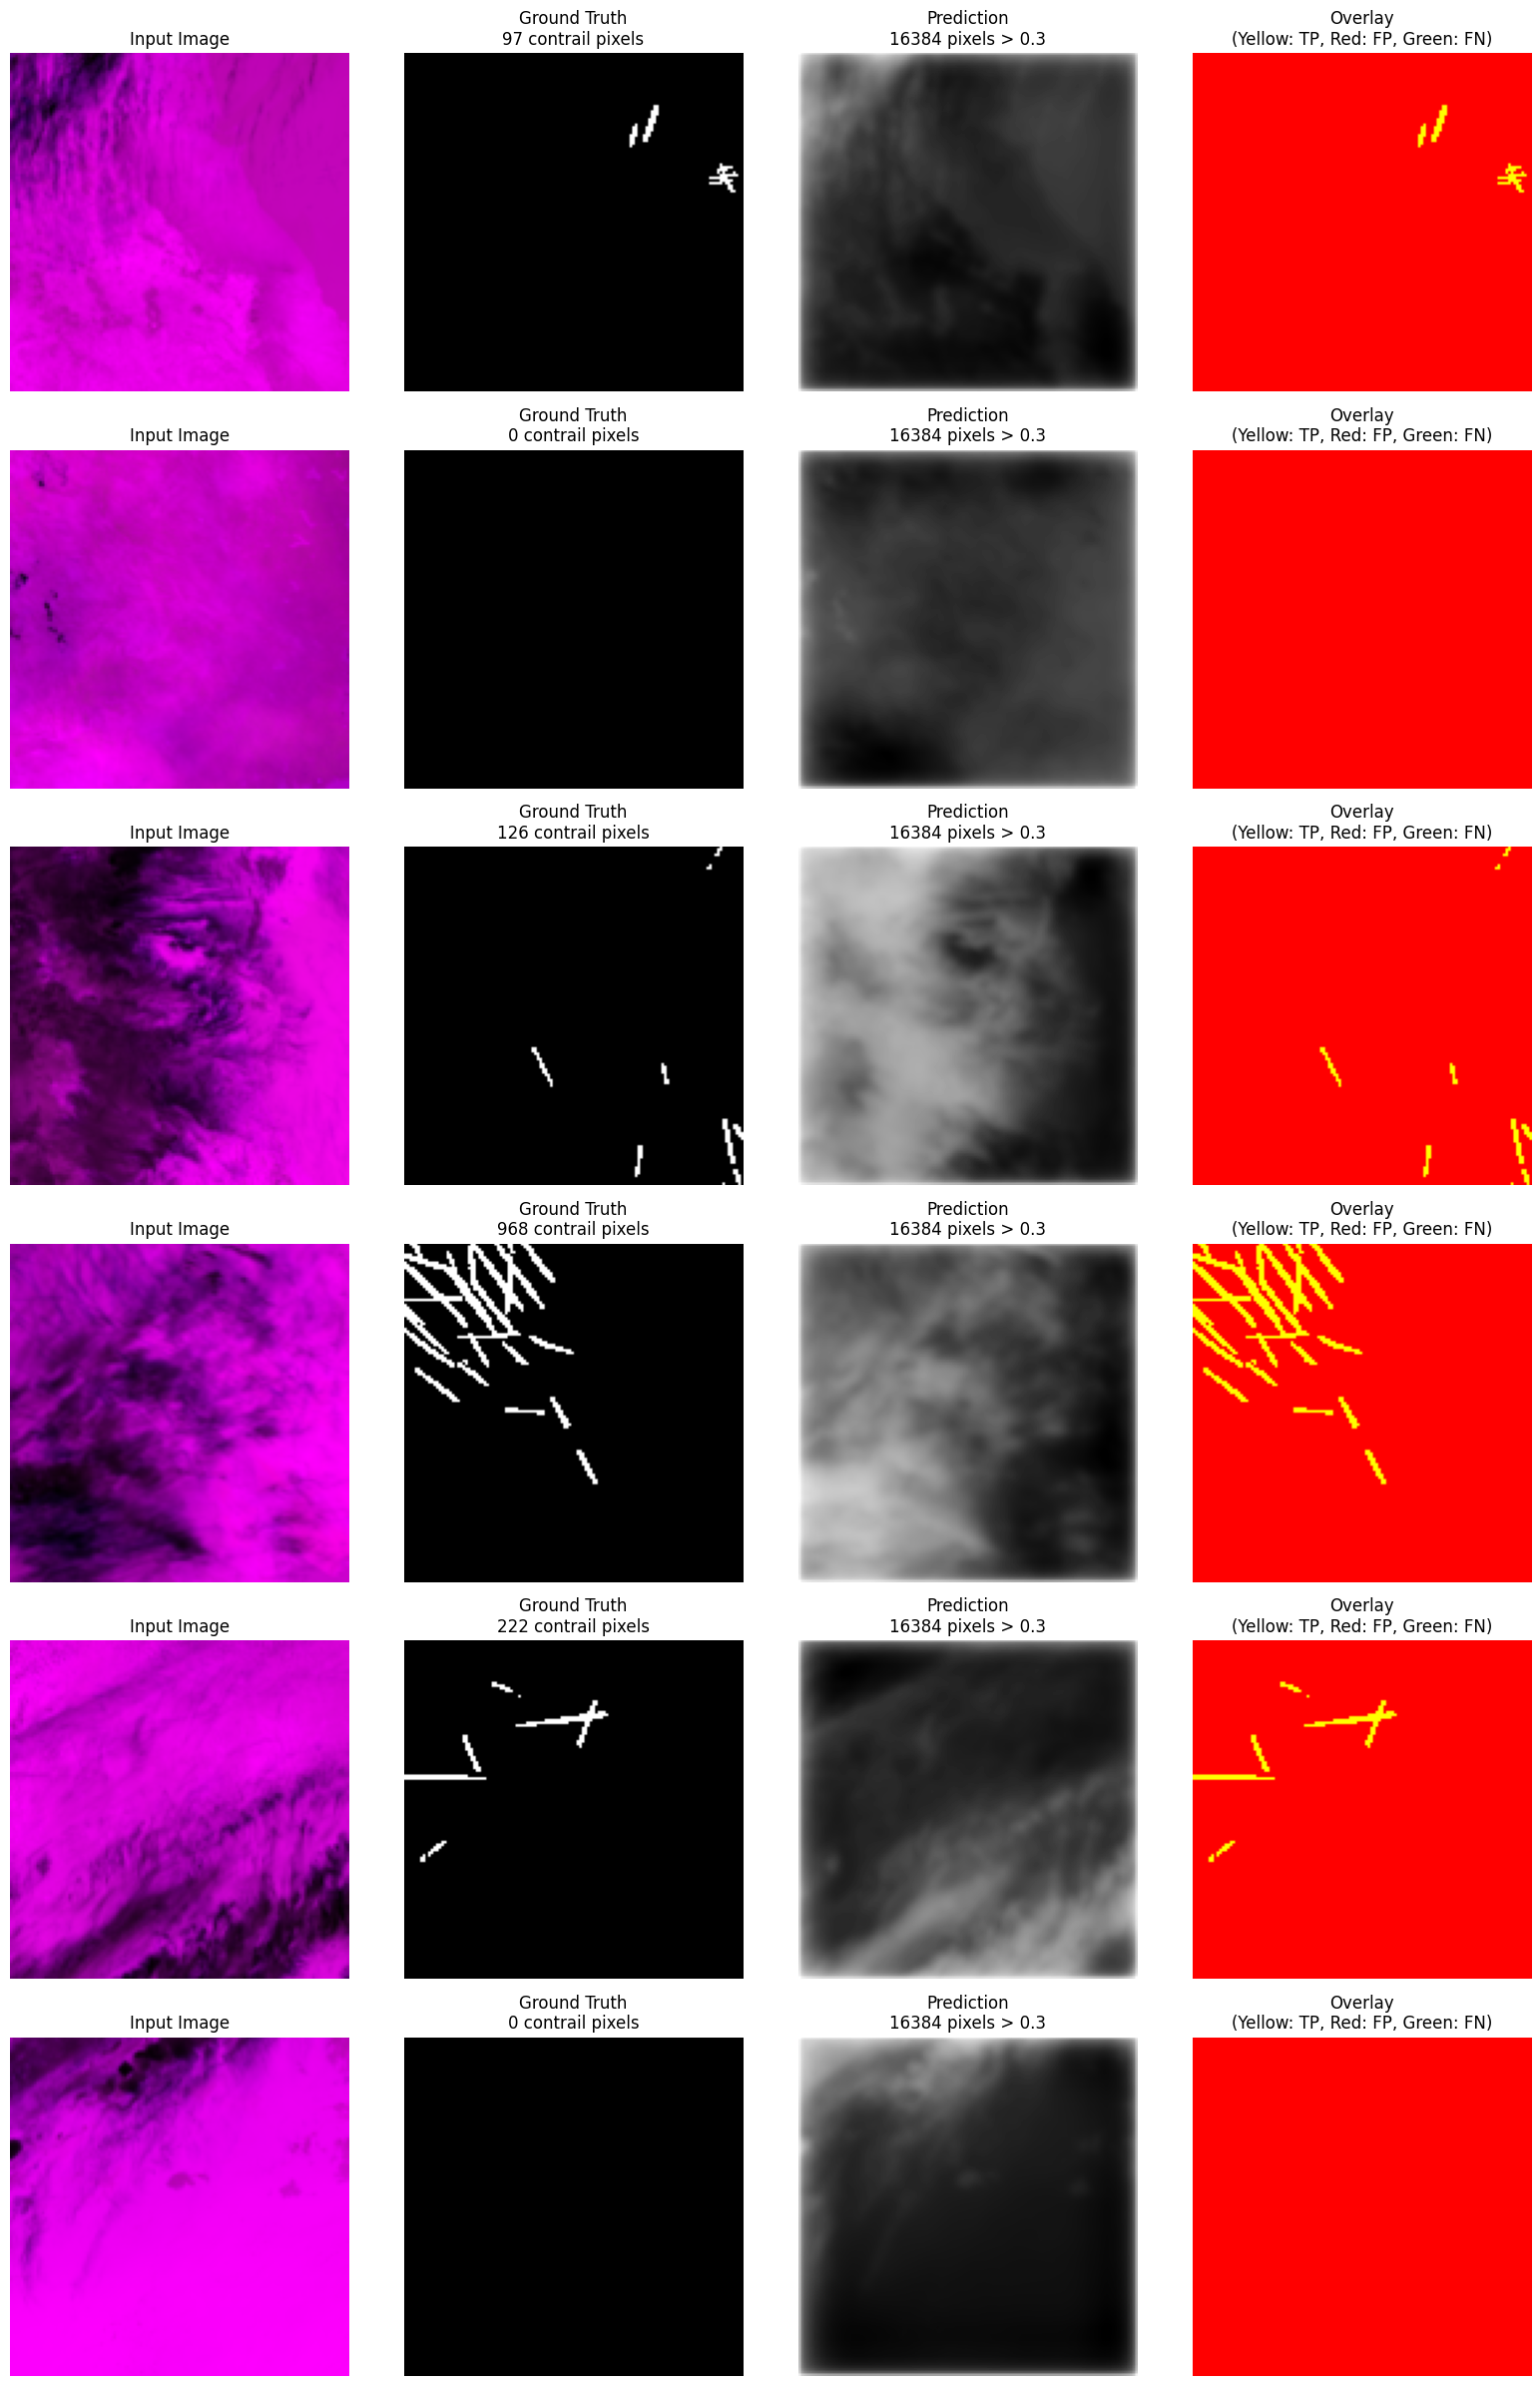

Model saved as 'final_contrail_detector.h5'
Training completed!


In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Configuration
CONFIG = {
    'img_height': 128,
    'img_width': 128,
    'batch_size': 16,
    'epochs': 1,
    'learning_rate': 1e-4,
    'random_seed': 42
}

# Set random seeds
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Load metadata
print("Loading metadata...")
with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    train_meta = json.load(f)

print(f"Training samples: {len(train_meta)}")

BASE_PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

def load_and_preprocess_sample(record_id):
    """Load and preprocess sample"""
    record_path = os.path.join(TRAIN_PATH, record_id)
    
    try:
        band15 = np.load(os.path.join(record_path, "band_15.npy"))
        band14 = np.load(os.path.join(record_path, "band_14.npy")) 
        band11 = np.load(os.path.join(record_path, "band_11.npy"))
        human_pixel_masks = np.load(os.path.join(record_path, "human_pixel_masks.npy"))
        
        # Use middle timestep
        t = band15.shape[2] // 2
        band15_t = band15[:, :, t]
        band14_t = band14[:, :, t] 
        band11_t = band11[:, :, t]
        
        # Convert to tensors and normalize
        band15_tensor = tf.convert_to_tensor(band15_t, dtype=tf.float32)
        band14_tensor = tf.convert_to_tensor(band14_t, dtype=tf.float32)
        band11_tensor = tf.convert_to_tensor(band11_t, dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(human_pixel_masks, dtype=tf.float32)
        
        def normalize_tensor(tensor):
            tensor_min = tf.reduce_min(tensor)
            tensor_max = tf.reduce_max(tensor)
            return (tensor - tensor_min) / (tensor_max - tensor_min + 1e-8)
        
        band15_norm = normalize_tensor(band15_tensor)
        band14_norm = normalize_tensor(band14_tensor)
        band11_norm = normalize_tensor(band11_tensor)
        
        # Create RGB using temperature difference for contrails
        temp_diff = band15_norm - band14_norm  # This highlights contrails!
        image = tf.stack([band15_norm, temp_diff, band11_norm], axis=-1)
        
        # Handle mask
        if len(mask_tensor.shape) == 3:
            mask_tensor = tf.squeeze(mask_tensor)
        
        # Resize
        image_resized = tf.image.resize(image, [CONFIG['img_height'], CONFIG['img_width']])
        mask_resized = tf.image.resize(tf.expand_dims(mask_tensor, axis=-1), 
                                     [CONFIG['img_height'], CONFIG['img_width']])
        mask_binary = tf.cast(mask_resized > 0, tf.float32)
        mask_binary = tf.squeeze(mask_binary)
        
        return image_resized.numpy(), mask_binary.numpy()
        
    except Exception as e:
        return None, None

def create_balanced_dataset(metadata, num_samples=500):
    """Create dataset with proper class balancing"""
    images = []
    masks = []
    
    print(f"Loading {num_samples} samples...")
    
    positive_count = 0
    negative_count = 0
    
    for i, meta in enumerate(tqdm(metadata[:num_samples])):
        record_id = meta['record_id']
        image, mask = load_and_preprocess_sample(record_id)
        
        if image is not None:
            contrail_pixels = np.sum(mask > 0)
            
            # Balance the dataset
            if contrail_pixels > 10:  # Has contrails
                images.append(image)
                masks.append(mask)
                positive_count += 1
            elif negative_count < positive_count:  # Limit negatives
                images.append(image)
                masks.append(mask)
                negative_count += 1
    
    print(f"Dataset: {positive_count} positive, {negative_count} negative samples")
    print(f"Total contrail pixels: {np.sum(masks) if masks else 0}")
    
    return np.array(images), np.array(masks)

# Custom loss functions to handle imbalance
class WeightedBinaryCrossentropy(keras.losses.Loss):
    def __init__(self, pos_weight=50.0, name="weighted_bce"):
        super().__init__(name=name)
        self.pos_weight = pos_weight
    
    def call(self, y_true, y_pred):
        # Calculate binary crossentropy
        bce = keras.backend.binary_crossentropy(y_true, y_pred)
        
        # Apply weights
        weight_vector = y_true * self.pos_weight + (1. - y_true) * 1.0
        weighted_bce = weight_vector * bce
        
        return keras.backend.mean(weighted_bce)

def dice_loss(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = WeightedBinaryCrossentropy(pos_weight=50.0)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Create a better model with attention
def create_attention_unet(input_shape=(128, 128, 3)):
    """U-Net with attention for better contrail detection"""
    
    def attention_gate(g, x, filters):
        """Attention gate to focus on contrail regions"""
        g1 = layers.Conv2D(filters, 1, padding='same')(g)
        x1 = layers.Conv2D(filters, 1, padding='same')(x)
        psi = layers.Activation('relu')(layers.add([g1, x1]))
        psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(psi)
        return layers.multiply([x, psi])
    
    inputs = layers.Input(shape=input_shape)
    
    # Downsample
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    
    # Upsample with attention
    u1 = layers.UpSampling2D(2)(c4)
    att1 = attention_gate(u1, c3, 256)
    u1 = layers.concatenate([u1, att1])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)
    
    u2 = layers.UpSampling2D(2)(c5)
    att2 = attention_gate(u2, c2, 128)
    u2 = layers.concatenate([u2, att2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)
    
    u3 = layers.UpSampling2D(2)(c6)
    att3 = attention_gate(u3, c1, 64)
    u3 = layers.concatenate([u3, att3])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)
    
    # Output with sigmoid
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
    
    model = keras.Model(inputs, outputs)
    return model

# Create dataset
print("Creating balanced dataset...")
train_images, train_masks = create_balanced_dataset(train_meta, num_samples=1000)

if len(train_images) == 0:
    print("ERROR: No samples loaded! Loading first 50 samples regardless...")
    train_images, train_masks = [], []
    for i in range(min(50, len(train_meta))):
        image, mask = load_and_preprocess_sample(train_meta[i]['record_id'])
        if image is not None:
            train_images.append(image)
            train_masks.append(mask)
    train_images, train_masks = np.array(train_images), np.array(train_masks)

print(f"Final dataset: {train_images.shape}")

# Add channel dimension
train_masks_expanded = np.expand_dims(train_masks, axis=-1)

# Analyze class distribution
total_pixels = train_masks_expanded.size
contrail_pixels = np.sum(train_masks_expanded > 0)
background_pixels = total_pixels - contrail_pixels

print(f"\nClass Distribution:")
print(f"Contrail pixels: {contrail_pixels} ({contrail_pixels/total_pixels*100:.4f}%)")
print(f"Background pixels: {background_pixels} ({background_pixels/total_pixels*100:.4f}%)")

# Calculate class weights
contrail_weight = total_pixels / (2 * contrail_pixels) if contrail_pixels > 0 else 1.0
background_weight = total_pixels / (2 * background_pixels)

print(f"Class weights - Background: {background_weight:.2f}, Contrails: {contrail_weight:.2f}")

# Split data
if len(train_images) > 5:
    train_im, val_im, train_mask, val_mask = train_test_split(
        train_images, train_masks_expanded, test_size=0.2, random_state=CONFIG['random_seed']
    )
    
    print(f"\nTraining: {train_im.shape}, Validation: {val_im.shape}")
    
    # Create model with attention
    print("Creating attention U-Net model...")
    model = create_attention_unet(input_shape=(CONFIG['img_height'], CONFIG['img_width'], 3))
    
    # Use combined loss with high weight for contrails
    model.compile(
        optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
        loss=combined_loss,
        metrics=['accuracy', 
                 keras.metrics.IoU(num_classes=2, target_class_ids=[1], name='iou'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    
    print("Model summary:")
    model.summary()
    
    # Custom callback to monitor progress
    class ContrailsMonitor(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            iou = logs.get('val_iou', 0)
            precision = logs.get('val_precision', 0)
            recall = logs.get('val_recall', 0)
            print(f"Epoch {epoch+1}: IoU={iou:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
    
    # Callbacks
    callbacks = [
        ContrailsMonitor(),
        keras.callbacks.EarlyStopping(
            patience=15, 
            restore_best_weights=True, 
            monitor='val_iou',
            mode='max'
        ),
        keras.callbacks.ReduceLROnPlateau(
            patience=8,
            factor=0.5,
            min_lr=1e-7,
            monitor='val_loss'
        ),
        keras.callbacks.ModelCheckpoint(
            'best_contrail_model.h5',
            save_best_only=True,
            monitor='val_iou',
            mode='max'
        )
    ]
    
    # Train model
    print("Starting training with class balancing...")
    history = model.fit(
        train_im, train_mask,
        validation_data=(val_im, val_mask),
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Load best model
    model.load_weights('best_contrail_model.h5')
    
    # Final evaluation
    print("\n=== FINAL EVALUATION ===")
    results = model.evaluate(val_im, val_mask, verbose=0)
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value:.4f}")
    
    # Detailed visualization
    print("\n=== DETAILED PREDICTION ANALYSIS ===")
    predictions = model.predict(val_im[:6], verbose=0)
    
    fig, axes = plt.subplots(6, 4, figsize=(16, 24))
    
    for i in range(6):
        # Input image
        axes[i, 0].imshow(val_im[i])
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt = val_mask[i].squeeze()
        axes[i, 1].imshow(gt, cmap='gray')
        gt_pixels = np.sum(gt > 0)
        axes[i, 1].set_title(f'Ground Truth\n{gt_pixels} contrail pixels')
        axes[i, 1].axis('off')
        
        # Prediction
        pred = predictions[i].squeeze()
        axes[i, 2].imshow(pred, cmap='gray')
        pred_pixels = np.sum(pred > 0.3)  # Lower threshold for visualization
        axes[i, 2].set_title(f'Prediction\n{pred_pixels} pixels > 0.3')
        axes[i, 2].axis('off')
        
        # Overlay
        overlay = val_im[i].copy()
        # Red for predictions, Green for ground truth, Yellow for overlap
        pred_mask = pred > 0.3
        gt_mask = gt > 0
        
        # True positives (yellow)
        tp_mask = np.logical_and(pred_mask, gt_mask)
        overlay[tp_mask] = [1, 1, 0]  # Yellow
        
        # False positives (red)
        fp_mask = np.logical_and(pred_mask, np.logical_not(gt_mask))
        overlay[fp_mask] = [1, 0, 0]  # Red
        
        # False negatives (green)
        fn_mask = np.logical_and(np.logical_not(pred_mask), gt_mask)
        overlay[fn_mask] = [0, 1, 0]  # Green
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay\n(Yellow: TP, Red: FP, Green: FN)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save final model
    model.save('final_contrail_detector.h5')
    print("Model saved as 'final_contrail_detector.h5'")
    
else:
    print("Not enough samples for training")

print("Training completed!")